## Machine Learning Modeling

In [25]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

flights = pd.read_csv('final_data.csv', index_col=0)

In [26]:
#Preview first 5 rows of the dataste
flights.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DELAYED
0,705,125,634,810,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1859,189,1028,2208,337,0,0,82,255,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,1735,147,931,2102,-19,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1815,185,1436,2320,-7,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2125,100,481,2305,13,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


### Functions Used for Project

Several functions will be used to automate the process in our notebook. The functions used are printed below.

In [27]:
#write function to train and predict model, then print score results 

def model_fit(smotex, smotey, trainx, trainy, testx, testy, model, name):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    result = {'model': name}
    
    result['train_accuracy'] = np.around((accuracy_score(trainy, train_prediction)), decimals=3)
    result['train_precision'] = np.around((precision_score(trainy, train_prediction)), decimals=3)
    result['train_recall'] = np.around((recall_score(trainy, train_prediction)), decimals=3)
    result['train_f1'] = np.around((f1_score(trainy, train_prediction)), decimals=3)
    
    result['test_accuracy'] = np.around((accuracy_score(testy, test_prediction)), decimals=3)
    result['test_precision'] = np.around((precision_score(testy, test_prediction)), decimals=3)
    result['test_recall'] = np.around((recall_score(testy, test_prediction)), decimals=3)
    result['test_f1'] = np.around((f1_score(testy, test_prediction)), decimals=3)
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print("Train Set Accuracy:", result['train_accuracy'])
    print("Train Set Precision:", result['train_precision'])
    print("Train Set Recall:", result['train_recall'])
    print("Train Set F1-Score:", result['train_f1'])

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction)) 
                                      
    print("Test Set Accuracy:", result['test_accuracy'])  
    print("Test Set Precision:", result['test_precision']) 
    print("Test Set Recall:", result['test_recall'])
    print("Test Set F1-Score:", result['test_f1'])
                                      
    
    print("\n")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    trainmatrix = plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues, ax=ax1)
    testmatrix = plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues, ax=ax2)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return result

In [71]:
# function for plotting a feature importance histogram (very similar to function above - may not need both)
def features_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = df, orient = 'h', color = 'blue') \
       .set_title(title, fontsize = 20)

In [72]:
#Function for creating a feature importance dataframe
def features_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

### Train Test Split

In [28]:
#Explore the class distribution of the target variable 
flights['DELAYED'].value_counts()

0    6384
1    3616
Name: DELAYED, dtype: int64

In [29]:
#Set X and y values 
y = flights['DELAYED']
X = flights.drop(['DELAYED'], axis=1)

In [30]:
#Investigate the value counts of our target variable 
y.value_counts(normalize=True)

0    0.6384
1    0.3616
Name: DELAYED, dtype: float64

In [31]:
#Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We see that there is quite a bit of a class imbalance in our target variable; 62.8% of our flights were not delayed while only 37.1% were delayed. As a result, we will apply a SMOTE technique in order to create synthesized data in order to improve our model. 

In [32]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    6384
1    3616
Name: DELAYED, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4795
0    4795
Name: DELAYED, dtype: int64


### 1. KNN

In [33]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

#Scale original X_train and X_test
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

#Scale the resampled train 
X_train_resampled_scaled = scaler.transform(X_train_resampled)  

In [34]:
#Fit and predict the vanilla model
knnmodel = KNeighborsClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      4795
           1       0.70      0.75      0.73      2705

    accuracy                           0.80      7500
   macro avg       0.78      0.79      0.78      7500
weighted avg       0.80      0.80      0.80      7500

Train Set Accuracy: 0.795
Train Set Precision: 0.701
Train Set Recall: 0.753
Train Set F1-Score: 0.726


Test Score Results
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1589
           1       0.48      0.51      0.50       911

    accuracy                           0.62      2500
   macro avg       0.59      0.60      0.60      2500
weighted avg       0.63      0.62      0.62      2500

Test Set Accuracy: 0.62
Test Set Precision: 0.48
Test Set Recall: 0.514
Test Set F1-Score: 0.496




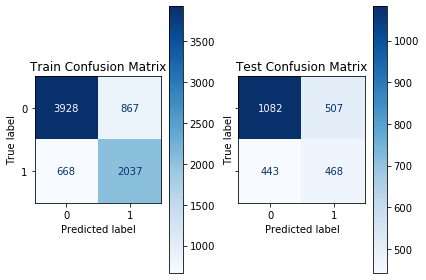

In [35]:
#Apply the model and print metrics
knnresult = model_fit(X_train_resampled_scaled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, knnmodel, 'knn')

### 2. Bayes Classification Model

In [36]:
#Instansiate the vanilla model
bayes = GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      4795
           1       0.97      0.43      0.60      2705

    accuracy                           0.79      7500
   macro avg       0.86      0.71      0.73      7500
weighted avg       0.83      0.79      0.76      7500

Train Set Accuracy: 0.79
Train Set Precision: 0.965
Train Set Recall: 0.433
Train Set F1-Score: 0.597


Test Score Results
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1589
           1       0.98      0.41      0.58       911

    accuracy                           0.78      2500
   macro avg       0.86      0.70      0.72      2500
weighted avg       0.83      0.78      0.75      2500

Test Set Accuracy: 0.782
Test Set Precision: 0.979
Test Set Recall: 0.412
Test Set F1-Score: 0.58




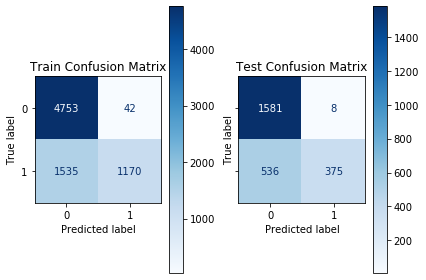

In [37]:
#Apply the modelfit function
bayesresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bayes, 'bayes')

### 3. Decision Tree Classifier

In [100]:
#Instansiate the vanilla model 
decisiontree = DecisionTreeClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1589
           1       0.65      0.67      0.66       911

    accuracy                           0.75      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.75      0.75      0.75      2500

Test Set Accuracy: 0.75
Test Set Precision: 0.652
Test Set Recall: 0.67
Test Set F1-Score: 0.661




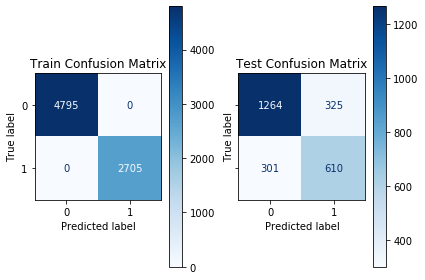

In [101]:
#Apply the model fit function 
decisiontreeresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, decisiontree, 'decisiontree')

In [103]:
#Look at feature importances of our decision tree 
features = features_df(X_train.columns, decisiontree.feature_importances_)
features

,feature,feature_importance
0,ARRIVAL_DELAY,0.427824
1,SCHEDULED_ARRIVAL,0.057021
2,SCHEDULED_DEPARTURE,0.055369
3,DISTANCE,0.054240
4,SCHEDULED_TIME,0.048410
5,AIRLINE_United Air Lines Inc.,0.041796
6,AIRLINE_Southwest Airlines Co.,0.033521
7,LATE_AIRCRAFT_DELAY,0.031964
8,AIRLINE_DELAY,0.026239
9,DESTINATION_AIRPORT_TYPE_Low,0.009940


The most important feature in our model is the "Arrival Delay" - this is expected, as our target variable measures the departure delay, and an arrival delay would likely follow. However, the remaining features have quite low feature importance values and with this current model, it is difficult to make any conclusions as to which features may have a stronger impact on our predictions.

### 4. Ensemble Methods

#### a. Bagging Method

In [40]:
#Instansiate the vanilla model
bagged_tree = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=20)



Train Score Results
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4795
           1       1.00      0.99      0.99      2705

    accuracy                           1.00      7500
   macro avg       1.00      0.99      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 0.996
Train Set Precision: 1.0
Train Set Recall: 0.99
Train Set F1-Score: 0.995


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1589
           1       0.76      0.64      0.70       911

    accuracy                           0.80      2500
   macro avg       0.79      0.76      0.77      2500
weighted avg       0.79      0.80      0.79      2500

Test Set Accuracy: 0.798
Test Set Precision: 0.763
Test Set Recall: 0.644
Test Set F1-Score: 0.699




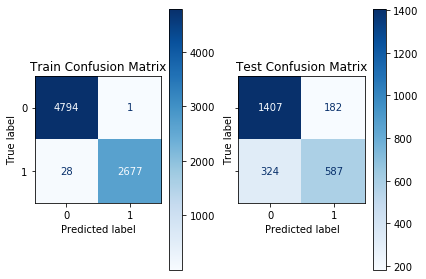

In [41]:
#Apply the model prediction
baggingresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bagged_tree, 'bagging')

#### b. Random Forest

In [42]:
#Instansiate the vanilla model 
randomforest = RandomForestClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       1.00      1.00      1.00      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0
Train Set Precision: 1.0
Train Set Recall: 1.0
Train Set F1-Score: 1.0


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1589
           1       0.81      0.63      0.71       911

    accuracy                           0.81      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.81      0.81      0.81      2500

Test Set Accuracy: 0.814
Test Set Precision: 0.813
Test Set Recall: 0.634
Test Set F1-Score: 0.713




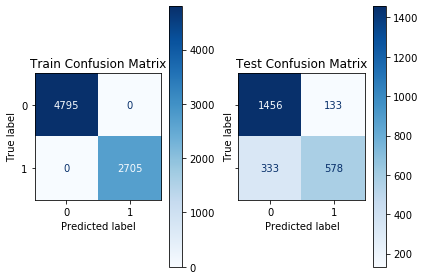

In [43]:
#Apply the model_fit function 
randomforestresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, randomforest, 'randomforest')

In [44]:
#Look at another performance measure: mean 3-Fold cross validation score 
mean_rf_cv_score = np.mean(cross_val_score(randomforest, X_train, y_train, cv=3))
mean_rf_cv_score

0.8192

### 5. Boosting

#### a. Adaboost

In [45]:
#Instansiate the vanilla model
adb = AdaBoostClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4795
           1       0.76      0.69      0.73      2705

    accuracy                           0.81      7500
   macro avg       0.80      0.79      0.79      7500
weighted avg       0.81      0.81      0.81      7500

Train Set Accuracy: 0.811
Train Set Precision: 0.762
Train Set Recall: 0.694
Train Set F1-Score: 0.726


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1589
           1       0.78      0.66      0.71       911

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.78      2500
weighted avg       0.81      0.81      0.80      2500

Test Set Accuracy: 0.808
Test Set Precision: 0.783
Test Set Recall: 0.655
Test Set F1-Score: 0.714




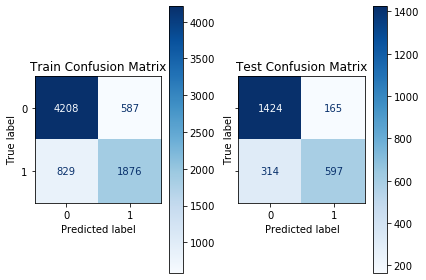

In [46]:
#Fit and predict model and show results
adbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, adb, 'Adaboost')

In [47]:
#Look at another performance measure: mean 3-Fold cross validation score 
adb_mean_cv = cross_val_score(adb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {adb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.22%


#### b. Gradient Boosting

In [48]:
#Instansiate the vanilla model
gb = GradientBoostingClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4795
           1       0.81      0.71      0.76      2705

    accuracy                           0.84      7500
   macro avg       0.83      0.81      0.82      7500
weighted avg       0.83      0.84      0.83      7500

Train Set Accuracy: 0.836
Train Set Precision: 0.814
Train Set Recall: 0.707
Train Set F1-Score: 0.756


Test Score Results
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1589
           1       0.80      0.68      0.74       911

    accuracy                           0.82      2500
   macro avg       0.82      0.79      0.80      2500
weighted avg       0.82      0.82      0.82      2500

Test Set Accuracy: 0.823
Test Set Precision: 0.802
Test Set Recall: 0.682
Test Set F1-Score: 0.737




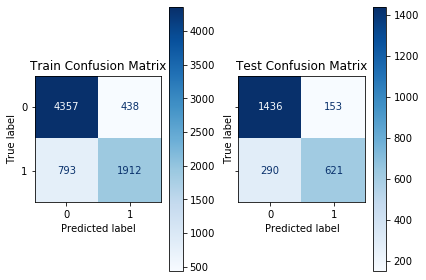

In [49]:
#Fit and predict model and show results
gbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, gb, 'Gradient_Boosting')

In [50]:
#Look at another performance measure: mean 3-Fold cross validation score 
gb_mean_cv = cross_val_score(gb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {gb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  82.34%


#### c. XGBoost

In [105]:
#Instansiate the vanilla model
xgb = XGBClassifier(random_state=0)



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4795
           1       0.82      0.70      0.75      2705

    accuracy                           0.83      7500
   macro avg       0.83      0.80      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.834
Train Set Precision: 0.815
Train Set Recall: 0.699
Train Set F1-Score: 0.752


Test Score Results
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1589
           1       0.81      0.67      0.73       911

    accuracy                           0.82      2500
   macro avg       0.82      0.79      0.80      2500
weighted avg       0.82      0.82      0.82      2500

Test Set Accuracy: 0.821
Test Set Precision: 0.805
Test Set Recall: 0.671
Test Set F1-Score: 0.732




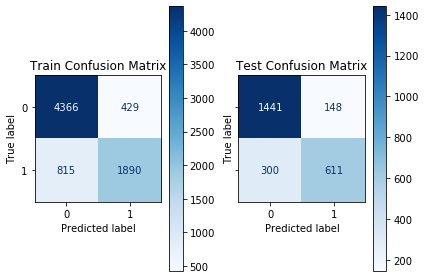

In [106]:
#Fit and predict model and show results
xgbresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, xgb, 'XGBoost')

In [53]:
#Investigate XGB cross val score 
xgb_mean_cv = cross_val_score(xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  82.17%


In [116]:
#Look at feature importance for the XGBoost model 
xgb_features = features_df(X_train.columns, xgb.feature_importances_)
xgb_features

,feature,feature_importance
0,ARRIVAL_DELAY,0.149247
1,ORIGIN_AIRPORT_TYPE_High,0.096441
2,AIRLINE_DELAY,0.061242
3,LATE_AIRCRAFT_DELAY,0.060216
4,ORIGIN_AIRPORT_TYPE_Medium,0.054459
5,AIRLINE_Southwest Airlines Co.,0.046907
6,DESTINATION_AIRPORT_TYPE_High,0.045170
7,AIRLINE_United Air Lines Inc.,0.041587
8,ORIGIN_AIRPORT_TYPE_Very Low,0.041208
9,DAY_OF_WEEK_2,0.036615


Again, arrival delay is the most important feature, however its value is lower than in our decision tree result. Interestingly, the next important feature is "Origin Airport Type - High" which represents airports with high aircraft traffic. This makes sense - if airports are experiencing a high volume of flights and are very busy, it is 1. with more flights, it is more likely that some are going to be delayed and 2. it could be more challenging to ensure flights are departing on time when there are limited resources at the airport itself but a high amount of flights that are departing. This feature importance value is quite low for now, but we will investigate this further when we tune our models.

### 6. Support Vector Machines

In [54]:
#Instansiate the vanilla model
svclassifier = SVC(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4795
           1       0.88      0.72      0.79      2705

    accuracy                           0.86      7500
   macro avg       0.87      0.83      0.84      7500
weighted avg       0.86      0.86      0.86      7500

Train Set Accuracy: 0.863
Train Set Precision: 0.88
Train Set Recall: 0.716
Train Set F1-Score: 0.79


Test Score Results
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1589
           1       0.77      0.58      0.66       911

    accuracy                           0.78      2500
   macro avg       0.78      0.74      0.75      2500
weighted avg       0.78      0.78      0.78      2500

Test Set Accuracy: 0.784
Test Set Precision: 0.771
Test Set Recall: 0.58
Test Set F1-Score: 0.662




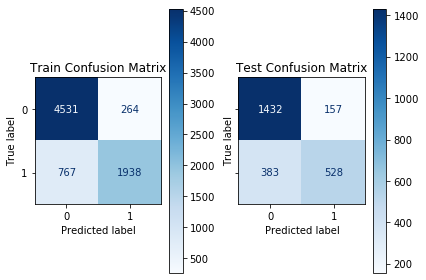

In [55]:
#Fit and predict model and show results. Note we are using the scaled data for the SVM model 
svmresult = model_fit(X_train_resampled_scaled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, svclassifier, 'SVM')

### All Vanilla Results

In [117]:
#Create list of all the Vanilla model results 
result_list = [knnresult, bayesresult, decisiontreeresult, baggingresult, 
                randomforestresult, adbresult, xgbresult, svmresult]

In [118]:
#Convert results into a dataframe 
df_results = pd.DataFrame.from_dict(result_list, orient='columns')
df_results = df_results.set_index('model')

In [119]:
#Preview results 
df_results

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
knn,0.795,0.701,0.753,0.726,0.620,0.480,0.514,0.496
bayes,0.790,0.965,0.433,0.597,0.782,0.979,0.412,0.580
decisiontree,1.000,1.000,1.000,1.000,0.750,0.652,0.670,0.661
bagging,0.996,1.000,0.990,0.995,0.798,0.763,0.644,0.699
randomforest,1.000,1.000,1.000,1.000,0.814,0.813,0.634,0.713
Adaboost,0.811,0.762,0.694,0.726,0.808,0.783,0.655,0.714
XGBoost,0.834,0.815,0.699,0.752,0.821,0.805,0.671,0.732
SVM,0.863,0.880,0.716,0.790,0.784,0.771,0.580,0.662


In the context of this project's problem, we are looking to optimize recall. In the results above, the test_recall scores are highest for Decision Tree (0.670) and XGBoost (0.671). As a result, in the next section, we will tune these models to determine if we can improve these recall results even further.

## Section B: Tuning Models


### Decision Tree

In [59]:
#Preview Decision Tree result again
decisiontreeresult

{'model': 'decisiontree',
 'train_accuracy': 1.0,
 'train_precision': 1.0,
 'train_recall': 1.0,
 'train_f1': 1.0,
 'test_accuracy': 0.75,
 'test_precision': 0.652,
 'test_recall': 0.67,
 'test_f1': 0.661}

In [67]:
#Select hyperparemeters for GridSearch to tune our decision tree model 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 11, 15], 
    'min_samples_split': [10, 20, 30, 40], 
    'min_samples_leaf': [10, 20, 30, 40]}

gs_dt = GridSearchCV(decisiontree, param_grid, scoring='recall', cv=10)

In [68]:
#Fit the GridSearch on the resampled data
gs_dt.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 11, 15],
                         'min_samples_leaf': [10, 20, 30, 40],
                         'min_samples_split': [10, 20, 30, 40]},
             scoring='recall')

In [69]:
#Print the best Train and Test Recall scores from the GridSearch, 
#Print the best parameters that helped reach this result 

print(f'Train Recall: {gs_dt.best_score_}')
dttest_recall = recall_score(y_test, gs_dt.predict(X_test))
print(f'Test Recall: {dttest_recall}')
print(gs_dt.best_params_)

Train Recall: 0.8270672407794016
Test Recall: 0.7497255762897914
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}


By introducing hyperparameters into the model, the results improved our test recall quite a bit, from 0.67 in our vanilla model to 0.75 in our tuned model. I will now redo training, fitting and predicting the model with these best parameters.

In [74]:
#Instansiate the new model with the best parameters as given above 
dttuned = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10, 
                                 min_samples_split=10, random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      4795
           1       0.66      0.80      0.73      2705

    accuracy                           0.78      7500
   macro avg       0.77      0.79      0.77      7500
weighted avg       0.80      0.78      0.79      7500

Train Set Accuracy: 0.783
Train Set Precision: 0.665
Train Set Recall: 0.8
Train Set F1-Score: 0.726


Test Score Results
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1589
           1       0.65      0.75      0.70       911

    accuracy                           0.76      2500
   macro avg       0.75      0.76      0.75      2500
weighted avg       0.77      0.76      0.77      2500

Test Set Accuracy: 0.764
Test Set Precision: 0.654
Test Set Recall: 0.75
Test Set F1-Score: 0.699




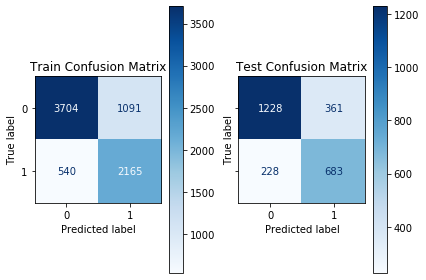

In [76]:
#Fit and predict model and show results
dttunedresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, dttuned, 'Decision Tree Tuned')

In [77]:
#Look at feature importance for the tuned cision tree  
overall_features = features_df(X_train.columns, dttuned.feature_importances_)
overall_features

,feature,feature_importance
0,ARRIVAL_DELAY,0.657554
1,LATE_AIRCRAFT_DELAY,0.119839
2,AIRLINE_DELAY,0.073511
3,AIRLINE_United Air Lines Inc.,0.050085
4,SCHEDULED_TIME,0.049343
5,AIRLINE_Southwest Airlines Co.,0.040416
6,AIRLINE_Hawaiian Airlines Inc.,0.005677
7,MONTH_3,0.002730
8,SCHEDULED_ARRIVAL,0.000845
9,DAY_OF_WEEK_2,0.000000


Many of the features have a feature importance of 0 in our decision tree. Before we plot the features on a graph, I will filter out the values that have 0 so we can have a cleaner visual as to which features are important in the results of our decision tree.

In [97]:
#Create new dataframe of all non-zero features 
overall_features_2 = overall_features[overall_features['feature_importance']>0]

In [98]:
#Print the. dataframe
overall_features_2

,feature,feature_importance
0,ARRIVAL_DELAY,0.657554
1,LATE_AIRCRAFT_DELAY,0.119839
2,AIRLINE_DELAY,0.073511
3,AIRLINE_United Air Lines Inc.,0.050085
4,SCHEDULED_TIME,0.049343
5,AIRLINE_Southwest Airlines Co.,0.040416
6,AIRLINE_Hawaiian Airlines Inc.,0.005677
7,MONTH_3,0.002730
8,SCHEDULED_ARRIVAL,0.000845


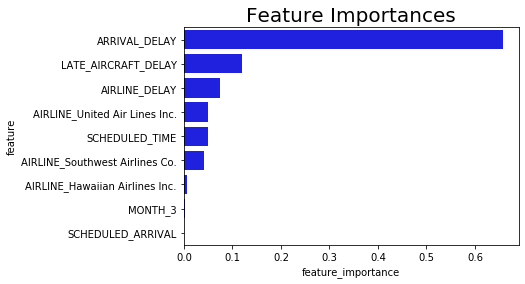

In [99]:
#Plot the feature importances 
features_plot(overall_features_2, 'Feature Importances')

The top 3 features in the plot above are particularly noteworthy; arrival delay, late aircraft delay, and airline delay are the more important features in this model. Unsurprisingly, an arrival delay would be a reult of a departure delay. Next, the top two features that are useful in our predictive analysis are late aircraft delays and airline delays. This concludes that while issues with weather, security, and airport delays could be highly influential in determining a departure delay, our model indicates that late aircrafts and airline delays are of higher importance in our model.

### 2. XGBoost

In [60]:
#Preview XGBoost results again 
xgbresult

{'model': 'XGBoost',
 'train_accuracy': 0.834,
 'train_precision': 0.815,
 'train_recall': 0.699,
 'train_f1': 0.752,
 'test_accuracy': 0.821,
 'test_precision': 0.805,
 'test_recall': 0.671,
 'test_f1': 0.732}

In [61]:
param_grid = {
    'max_depth': [1, 5, 8],
    'learning_rate': [.1, .15, 1], 
    'subsample': [.5, .9],
    'min_split_loss': [1, 3, 5],
    'n_estimators': [100, 500, 1000]
}
gs_xgb = GridSearchCV(xgb, param_grid, scoring='recall', cv=3)



In [45]:
gs_xgb.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.15, 1],
                         'max_depth': [1, 5, 8], 'min_split_loss': [1, 3, 5],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.5, 0.9]},
             scoring='recall')

In [46]:
print(f'Train Recall: {gs_xgb.best_score_}')
xgbtest_recall = recall_score(y_test, gs_xgb.predict(X_test))
print(f'Test Recall: {xgbtest_recall}')
print(gs_xgb.best_params_)

Train Recall: 0.7968181837690059
Test Recall: 0.6761904761904762
{'learning_rate': 1, 'max_depth': 8, 'min_split_loss': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [47]:
#Look at another performance measure: mean 3-Fold cross validation score 
xgb_mean_cv = cross_val_score(xgb, X, y, cv=3).mean()

print(f"Mean XGboost Cross-Val Score (k=3): {xgb_mean_cv: .2%}")

Mean XGboost Cross-Val Score (k=3):  81.76%


In [113]:
xgbtuned = XGBClassifier(learning_rate=1, max_depth=8, 
                         min_split_loss=3, n_estimators=1000, subsample=0.5)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4795
           1       0.99      0.99      0.99      2705

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 0.996
Train Set Precision: 0.995
Train Set Recall: 0.994
Train Set F1-Score: 0.995


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1589
           1       0.70      0.68      0.69       911

    accuracy                           0.77      2500
   macro avg       0.76      0.75      0.76      2500
weighted avg       0.77      0.77      0.77      2500

Test Set Accuracy: 0.775
Test Set Precision: 0.696
Test Set Recall: 0.677
Test Set F1-Score: 0.687




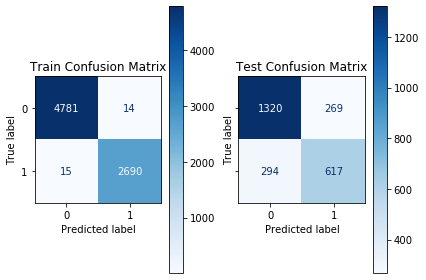

In [114]:
xgbtunedresult = model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, xgbtuned, 'XGBoost Tuned')

In [115]:
#Look at feature importance for the decision tree  
xgbtuned_features = features_df(X_train.columns, xgbtuned.feature_importances_)
xgbtuned_features

,feature,feature_importance
0,AIRLINE_DELAY,0.142143
1,LATE_AIRCRAFT_DELAY,0.078803
2,WEATHER_DELAY,0.031664
3,ARRIVAL_DELAY,0.029756
4,AIRLINE_United Air Lines Inc.,0.025523
5,AIRLINE_Alaska Airlines Inc.,0.022491
6,AIRLINE_Southwest Airlines Co.,0.021456
7,DAY_OF_WEEK_1,0.020633
8,DAY_OF_WEEK_7,0.020034
9,AIR_SYSTEM_DELAY,0.019204


In [120]:
#Something here that would analyze feature importances after we tune this model properly

## Conclusion and Recommendations

In order to interpret the results, it is crucial that we compare both the train and test results from the tuned models to the results from the vanilla models. I will build a DataFrame that shows these results side by side so that the interpretation is as reader-friendly as possible. 

In [127]:
result_list_updated = [decisiontreeresult, dttunedresult, xgbresult, xgbtunedresult]

In [128]:
#Convert results into a dataframe
df_results_updated = pd.DataFrame.from_dict(result_list_updated, orient='columns')
df_results_updated = df_results_updated.set_index('model')

In [129]:
df_results_updated

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
decisiontree,1.000,1.000,1.000,1.000,0.750,0.652,0.670,0.661
Decision Tree Tuned,0.783,0.665,0.800,0.726,0.764,0.654,0.750,0.699
XGBoost,0.834,0.815,0.699,0.752,0.821,0.805,0.671,0.732
XGBoost Tuned,0.996,0.995,0.994,0.995,0.775,0.696,0.677,0.687
